Resolution of image: 1920 x 1080


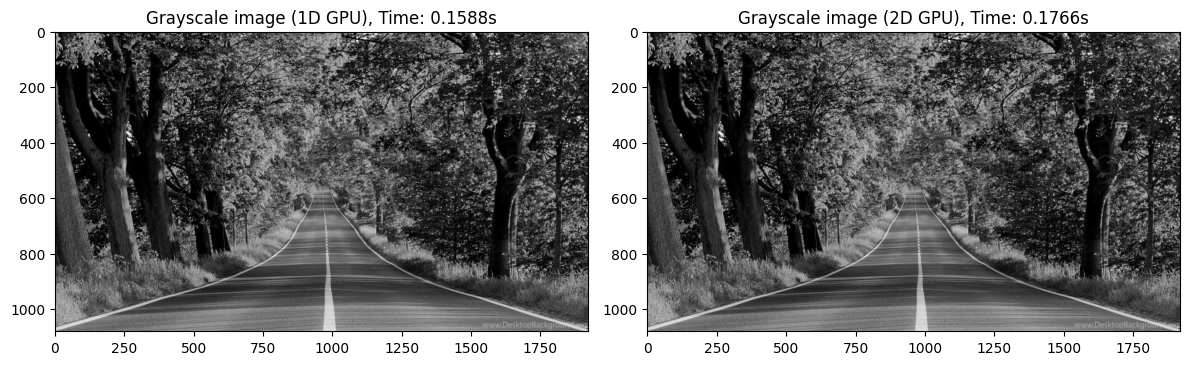

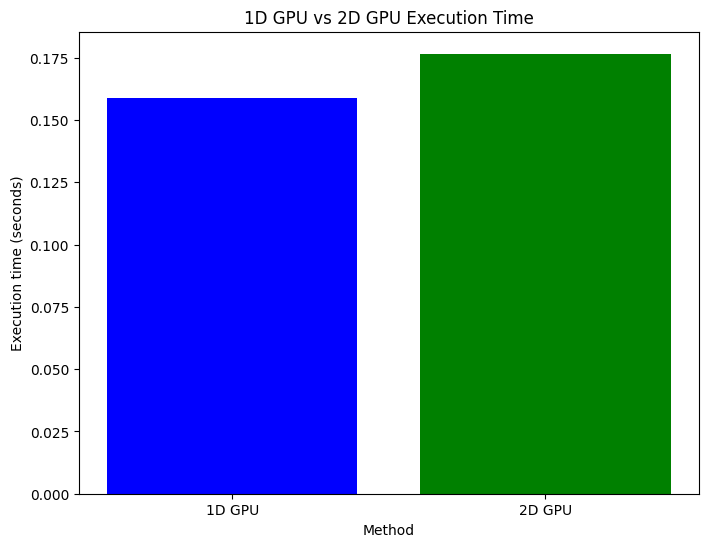

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
import matplotlib
# matplotlib.use('TkAgg')

@cuda.jit
def rgb_to_grayscale_gpu_1d(img, gray_img):
    i = cuda.grid(1)  # The grid and block are organized in a 1-dimensional (linear) structure
    if i < img.shape[0]:
        gray_img[i] =  (img[i, 0] + img[i, 1] + img[i, 2])/3

@cuda.jit
def rgb_to_grayscale_gpu_2d(img, gray_img):
    x, y = cuda.grid(2)  # The grid and block are organized in 2D
    if x < img.shape[0] and y < img.shape[1]: # boundary check
        gray_img[x, y] = (img[x, y, 0] + img[x, y, 1] + img[x, y, 2])/3

def process_image_1d(img):
    pixel_count = img.shape[0] * img.shape[1]
    img_flat = img.reshape(pixel_count, 3)

    gray_img_gpu = np.zeros(pixel_count, dtype=np.float32)

    img_flat_device = cuda.to_device(img_flat)
    gray_img_gpu_device = cuda.device_array(pixel_count, dtype=np.float32)

    threads_per_block = 256
    blocks_per_grid = (pixel_count + (threads_per_block - 1)) // threads_per_block

    start_gpu = time.time()
    rgb_to_grayscale_gpu_1d[blocks_per_grid, threads_per_block](img_flat_device, gray_img_gpu_device)
    cuda.synchronize()
    gray_img_gpu_device.copy_to_host(gray_img_gpu)
    end_gpu = time.time()

    return gray_img_gpu.reshape(img.shape[0], img.shape[1]), end_gpu - start_gpu

def process_image_2d(img):
    gray_img_gpu = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

    img_device = cuda.to_device(img) # transfer data
    gray_img_gpu_device = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.float32) # create gray image

    threads_per_block = (16, 16) # 16x16 thread per block
    blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0] # calculate number of block
    blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    start_gpu = time.time()
    rgb_to_grayscale_gpu_2d[blocks_per_grid, threads_per_block](img_device, gray_img_gpu_device) # launch kernel - execute on GPU
    cuda.synchronize()
    gray_img_gpu = gray_img_gpu_device.copy_to_host()
    end_gpu = time.time()

    return gray_img_gpu, end_gpu - start_gpu

# Load the image
img = plt.imread('/content/highest_reso.jpeg')
print(f"Resolution of image: {img.shape[1]} x {img.shape[0]}")

# Process the image using 1D and 2D GPU methods
gray_img_gpu_1d, gpu_time_1d = process_image_1d(img)
gray_img_gpu_2d, gpu_time_2d = process_image_2d(img)

# Display grayscale images for 1D and 2D
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_img_gpu_1d, cmap='gray')
plt.title(f"Grayscale image (1D GPU), Time: {gpu_time_1d:.4f}s")

plt.subplot(1, 2, 2)
plt.imshow(gray_img_gpu_2d, cmap='gray')
plt.title(f"Grayscale image (2D GPU), Time: {gpu_time_2d:.4f}s")

plt.tight_layout()
plt.show()

# Plot the execution time comparison
labels = ['1D GPU', '2D GPU']
times = [gpu_time_1d, gpu_time_2d]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'green'])
plt.xlabel('Method')
plt.ylabel('Execution time (seconds)')
plt.title('1D GPU vs 2D GPU Execution Time')
plt.show()

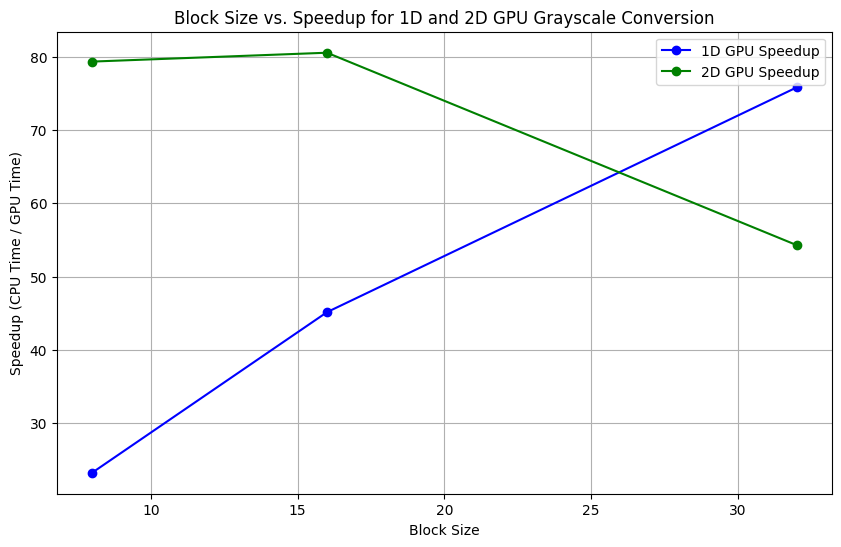

In [13]:
# Define baseline CPU function for grayscale conversion
def rgb_to_grayscale_cpu(img):
    return np.mean(img, axis=2)

# Measure the baseline CPU time
start_cpu = time.time()
gray_img_cpu = rgb_to_grayscale_cpu(img)
end_cpu = time.time()
cpu_time = end_cpu - start_cpu

# Define block sizes to test
block_sizes = [8, 16, 32]
speedups_1d = []
speedups_2d = []

for block_size in block_sizes:
    # Run 1D GPU processing with the current block size
    threads_per_block = block_size
    pixel_count = img.shape[0] * img.shape[1]
    img_flat = img.reshape(pixel_count, 3)

    gray_img_gpu = np.zeros(pixel_count, dtype=np.float32)

    img_flat_device = cuda.to_device(img_flat)
    gray_img_gpu_device = cuda.device_array(pixel_count, dtype=np.float32)

    blocks_per_grid = (pixel_count + (threads_per_block - 1)) // threads_per_block

    start_gpu = time.time()
    rgb_to_grayscale_gpu_1d[blocks_per_grid, threads_per_block](img_flat_device, gray_img_gpu_device)
    cuda.synchronize()
    end_gpu = time.time()

    gpu_time_1d = end_gpu - start_gpu
    speedups_1d.append(cpu_time / gpu_time_1d)  # Speedup for 1D

    # Run 2D GPU processing with the current block size
    threads_per_block = (block_size, block_size)
    blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    img_device = cuda.to_device(img)
    gray_img_gpu_device = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.float32)

    start_gpu = time.time()
    rgb_to_grayscale_gpu_2d[blocks_per_grid, threads_per_block](img_device, gray_img_gpu_device)
    cuda.synchronize()
    end_gpu = time.time()

    gpu_time_2d = end_gpu - start_gpu
    speedups_2d.append(cpu_time / gpu_time_2d)  # Speedup for 2D

# Plot the block size vs. speedup graph
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, speedups_1d, label='1D GPU Speedup', marker='o', color='blue')
plt.plot(block_sizes, speedups_2d, label='2D GPU Speedup', marker='o', color='green')
plt.xlabel('Block Size')
plt.ylabel('Speedup (CPU Time / GPU Time)')
plt.title('Block Size vs. Speedup for 1D and 2D GPU Grayscale Conversion')
plt.legend()
plt.grid(True)
plt.show()
